Following notes from this page: https://medium.com/modern-physics/finite-difference-solution-of-the-schrodinger-equation-c49039d161a8

In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial

In [2]:
# z-matrix for LiH
mol_str_LiH = """
Li
H 1 1.546938775510204
symmetry c1
"""

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.005]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

In [14]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 2
}

# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

# array  for energies inside the cavity
cavity_E_array_LiH = np.zeros((N_R, N_el))

r_data = np.linspace(1.5, 1.6, 50)
psi4.set_options(options_dict)
fci_S0 = []
fci_S1 = []
r_idx_LiH = 0
for r in r_data:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))
    LiH_cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_E_array_LiH[r_idx_LiH,:] = LiH_cav.CIeigs[:N_el]
    r_idx_LiH += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Wed Jan 24 15:41:05 2024

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> 

Min on S0 is 1.5469387755102042
Min on S1 is 1.6
Min on LP is 1.5489795918367348
146.92351441122435
94.4109358804805
144.96675692379657


<function matplotlib.pyplot.show(close=None, block=None)>

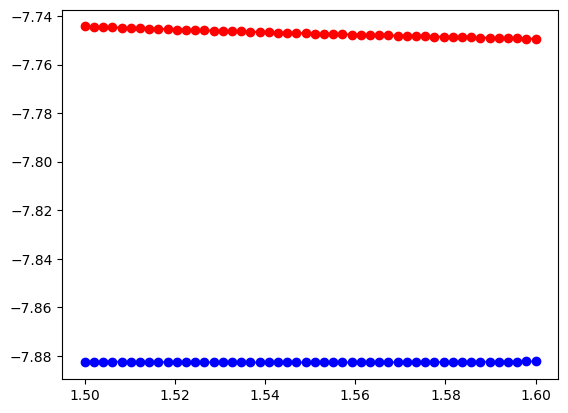

In [19]:
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
LP_array_1 = cavity_E_array_LiH[9:,2]
LP_array_2 = cavity_E_array_LiH[:9,1]
LP_array_full = np.concatenate((LP_array_2, LP_array_1), axis=0)
min_S0_loc = np.argmin(fci_S0[:])
min_S1_loc = np.argmin(fci_S1[:])
min_LP_loc = np.argmin(LP_array_full[:])
r_eq_ang = r_data[min_S0_loc]
r_eq_S1_ang = r_data[min_S1_loc]
r_eq_LP_ang = r_data[min_LP_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')
print(f'Min on S1 is {r_data[min_S1_loc]}')
print(f'Min on LP is {r_data[min_LP_loc]}')

mu_amu = 1.00784 * 6.9410 / (1.00784 + 6.9410)
mu_kg = mu_amu  * 10 ** (-3) / (6.022 * 10 ** 23) 
r_eq_SI = r_eq_ang * 10 ** (-10)
r_eq_S1_SI = r_eq_S1_ang * 10 ** (-10)

# Fitting S0 PES to a quintic polynomial
poly = np.poly1d(np.polyfit(r_data, fci_S0, 5))
poly_e = np.poly1d(np.polyfit(r_data, fci_S1, 5))
poly_LP = np.poly1d(np.polyfit(r_data, LP_array_full, 5))

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

first_derivative_S1 = poly_e.deriv()
second_derivative_S1 = first_derivative_S1.deriv()
k_test_S1_au = second_derivative_S1(r_eq_S1_ang)
k_test_S1_SI = k_test_S1_au * au_to_SI
print(k_test_S1_SI)

first_derivative_LP = poly_LP.deriv()
second_derivative_LP = first_derivative_LP.deriv()
k_test_LP_au = second_derivative_LP(r_eq_LP_ang)
k_test_LP_SI = k_test_LP_au * au_to_SI
print(k_test_LP_SI)




#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, fci_S0[:], 'bo', label='cavity free |g>')
plt.plot(r_data, poly_e(r_data), 'g-', label='fit')
plt.plot(r_data, fci_S1[:], 'ro', label='cavity free |e>')
plt.show

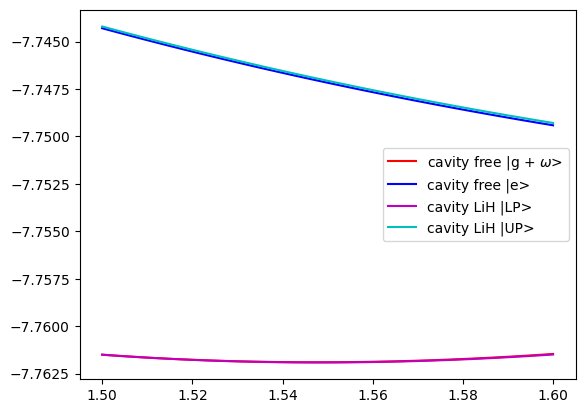

In [20]:
fci_S0_omega = np.zeros((1, 50))
for i in range(50):
    fci_S0_omega[0,i] = fci_S0[i] + 0.12086
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)




plt.plot(r_data, fci_S0_plusw, 'r-', label='cavity free |g + $\omega$>')
plt.plot(r_data, fci_S1, 'b-', label='cavity free |e>')
plt.plot(r_data, LP_array_full, 'm-', label='cavity LiH |LP>')
#plt.plot(r_data, cavity_E_array_LiH[:,1], 'g-', label='cavity LiH |TRIPLET>')
plt.plot(r_data, cavity_E_array_LiH[:,3], 'c-', label='cavity LiH |UP>')
#plt.xlim(0.6, 1.45)
plt.legend()
plt.show()

## Ground Electronic State

In [21]:
angstrom_to_bohr = 1.88973
x_min = 0.5 * 10 ** (-10)
x_max = 3.0 * 10 ** (-10)

hbar = scipy.constants.hbar
r_eq_SI = r_eq_ang * 10 ** (-10)
r_eq_au = r_eq_ang * angstrom_to_bohr

# number of grid points 
N = 1001

# define grid
x = np.linspace(x_min, x_max, N)

# define grid spacing h
h = x[1]-x[0]

def Vpot(x):
    return  1/2 * k_test_SI * (x - r_eq_SI) ** 2

V_x = Vpot(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T = np.zeros((N-2, N-2))
V = np.zeros((N-2, N-2))
H = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
H = -T * hbar ** 2 / (2 * mu_kg * h**2) + V

vals, vecs = np.linalg.eigh(H)
print(vals[0])
print(vecs[0,:])

1.6718595897829625e-20
[-7.71793865e-13  7.40580868e-12  4.96797195e-11 -2.68909001e-10
  1.24516063e-09  5.09134242e-09 -1.87519585e-08  6.30543642e-08
  1.95439861e-07 -5.62366974e-07 -1.51023590e-06  3.80034369e-06
 -8.98733265e-06 -2.00148257e-05  4.20240623e-05  8.32135818e-05
 -1.55284818e-04 -2.72589377e-04  4.48864743e-04 -6.91248714e-04
 -9.93943282e-04  1.33679436e-03  1.69206134e-03 -2.03512239e-03
 -2.35118081e-03  2.63522446e-03  2.88842349e-03 -3.11460008e-03
 -3.31810007e-03  3.50286216e-03  3.67215208e-03 -3.82858259e-03
 -3.97423197e-03  4.11079822e-03  4.23980423e-03 -4.36292273e-03
 -4.48248189e-03 -4.60200651e-03  4.72618252e-03  4.85948878e-03
 -5.00397305e-03 -5.15825560e-03  5.31882972e-03  5.48214603e-03
  5.64575001e-03 -5.80833690e-03 -5.96937536e-03  6.12874673e-03
  6.28651769e-03 -6.44282227e-03 -6.59780779e-03  6.75161290e-03
  6.90436046e-03 -7.05615660e-03 -7.20709215e-03 -7.35724472e-03
  7.50668079e-03  7.65545761e-03 -7.80362467e-03 -7.95122507e-03
  

## Excited Electronic State

In [22]:

r_eq_S1_SI = r_eq_S1_ang * 10 ** (-10)
r_eq_S1_au = r_eq_S1_ang * angstrom_to_bohr

def Vpot_e(x):
    return  1/2 * k_test_S1_SI * (x - r_eq_S1_SI) ** 2

V_x_e = Vpot_e(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T_e = np.zeros((N-2, N-2))
V_e = np.zeros((N-2, N-2))
H_e = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T_e[i,j]= -2
        elif np.abs(i-j)==1:
            T_e[i,j]=1
        else:
            T_e[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V_e[i,j]= Vpot_e(x[i+1])
        else:
            V_e[i,j]=0
            
H_e = -T_e * hbar ** 2 /(2 * mu_kg * h**2) + V_e

vals_e, vecs_e = np.linalg.eigh(H_e)
print(vals_e[0])
print(vecs_e[0,:])

1.340191245956133e-20
[-9.78607268e-12 -8.80946491e-11  5.53479037e-10 -2.80082484e-09
 -1.21006018e-08  4.60653304e-08 -1.57583221e-07 -4.90844018e-07
  1.40509836e-06  3.72134789e-06 -9.16231093e-06 -2.10403099e-05
  4.51543331e-05  9.06225394e-05 -1.69958945e-04  2.97231596e-04
  4.83248712e-04 -7.28648007e-04 -1.01949306e-03  1.33088126e-03
  1.63739067e-03 -1.92198419e-03 -2.17782722e-03  2.40512426e-03
  2.60734716e-03 -2.78894547e-03 -2.95460365e-03  3.10947048e-03
  3.25952073e-03  3.41090983e-03 -3.56794466e-03 -3.73142350e-03
  3.89929658e-03  4.06876921e-03 -4.23775587e-03 -4.40515274e-03
  4.57055046e-03  4.73390844e-03 -4.89534582e-03 -5.05503452e-03
 -5.21315164e-03  5.36986104e-03  5.52530784e-03 -5.67961833e-03
 -5.83290175e-03  5.98525252e-03  6.13675247e-03 -6.28747280e-03
 -6.43747568e-03  6.58681565e-03  6.73554078e-03 -6.88369355e-03
 -7.03131170e-03  7.17842882e-03  7.32507496e-03 -7.47127704e-03
 -7.61705925e-03  7.76244338e-03  7.90744914e-03 -8.05209434e-03
 -8

## Lower Polariton Surface

In [25]:
r_eq_LP_SI = r_eq_LP_ang * 10 ** (-10)
r_eq_LP_au = r_eq_LP_ang * angstrom_to_bohr

def Vpot_LP(x):
    return  1/2 * k_test_LP_SI * (x - r_eq_LP_SI) ** 2

V_x_LP = Vpot_LP(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T_LP = np.zeros((N-2, N-2))
V_LP = np.zeros((N-2, N-2))
H_LP = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T_LP[i,j]= -2
        elif np.abs(i-j)==1:
            T_LP[i,j]=1
        else:
            T_LP[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V_LP[i,j]= Vpot_LP(x[i+1])
        else:
            V_LP[i,j]=0
            
H_LP = -T_LP * hbar ** 2 /(2 * mu_kg * h**2) + V_LP

vals_LP, vecs_LP = np.linalg.eigh(H_LP)
print(vals_LP[0])
print(vecs_LP[0,:])

1.6606893787567312e-20
[-8.20338291e-13  7.86013350e-12  5.26486009e-11 -2.84542142e-10
  1.31547350e-09  5.37013012e-09 -1.97457381e-08  6.62815120e-08
  2.05075887e-07 -5.89000952e-07 -1.57871006e-06  3.96463879e-06
 -9.35599750e-06 -2.07891298e-05  4.35453970e-05  8.60033433e-05
 -1.60037091e-04 -2.80051323e-04  4.59545910e-04 -7.05007002e-04
 -1.00971079e-03  1.35278538e-03  1.70643853e-03 -2.04662051e-03
 -2.35928271e-03  2.63996716e-03  2.89011972e-03 -3.11364093e-03
 -3.31485711e-03  3.49765345e-03  3.66523884e-03 -3.82017886e-03
 -3.96452241e-03  4.09997148e-03  4.22812281e-03 -4.35085691e-03
 -4.47089624e-03 -4.59224788e-03  4.71977290e-03  4.85736845e-03
 -5.00590953e-03 -5.16306988e-03 -5.32514572e-03  5.48892893e-03
  5.65241102e-03 -5.81461353e-03 -5.97518817e-03  6.13410216e-03
  6.29145559e-03 -6.44739116e-03 -6.60205452e-03  6.75557903e-03
  6.90808158e-03  7.05966271e-03 -7.21040844e-03 -7.36039236e-03
  7.50967766e-03  7.65831886e-03 -7.80636328e-03 -7.95385217e-03
  

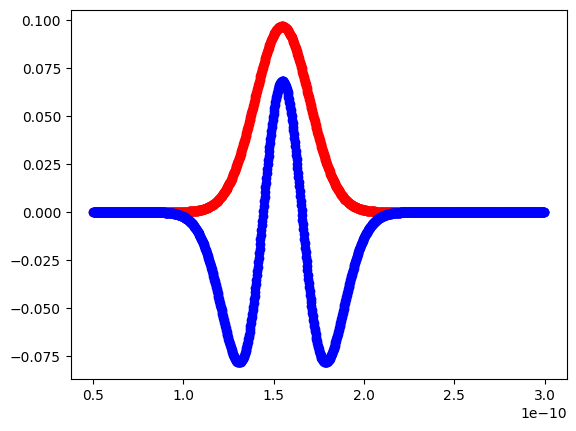

In [32]:
#plt.plot(x, V_x)
plt.plot(x[1:1000], -vecs[:,0], 'ro')
plt.plot(x[1:1000], -vecs_LP[:,2], 'bo')

## Franck-Condon Factor Calculation

In [53]:
#number of states + 1
states = 6
psi_g = np.zeros((1, states))
psi_LP = np.zeros((1, states))
FCF_int = np.zeros((states, states))
for i in range(states):
    for j in range(states):
        FCF_int[i,j] = np.trapz(vecs[:,i] * vecs_LP[:,j]) 
        FCF = np.absolute(FCF_int) ** 2 
print(FCF)

[[9.99903188e-01 9.14955365e-05 5.31488452e-06 1.50895195e-09
  4.14419931e-11 2.03106311e-14]
 [9.08841849e-05 9.99709577e-01 1.83590442e-04 1.59420488e-05
  6.04569234e-09 2.07182191e-10]
 [5.92616804e-06 1.81145140e-04 9.99504751e-01 2.76283095e-04
  3.18787111e-05 1.51388793e-08]
 [1.56485898e-09 1.77757356e-05 2.70781415e-04 9.99288716e-01
  3.69571840e-04 5.31219128e-05]
 [5.36815632e-11 6.24870959e-09 3.55457325e-05 3.59791591e-04
  9.99061477e-01 4.63454995e-04]
 [2.29074885e-14 2.68376317e-10 1.55948914e-08 5.92329874e-05
  4.48174280e-04 9.98823040e-01]]
